Shortcut

In [1]:
def a(round=4):
    return datasets.tail().round(round)

Initialize Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials as yf
from math import ceil, floor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

Import Datasets From Yahoo Finance

In [3]:
TICKER_NAME = 'SPY'
ticker = yf(TICKER_NAME)
raw_data = ticker.get_historical_price_data(start_date='1993-01-29', 
                                        end_date='2023-07-20', 
                                        time_interval='daily')
datasets = pd.DataFrame(raw_data[TICKER_NAME]['prices'])
datasets.drop('date', axis=1, inplace=True)
datasets.drop('adjclose', axis=1, inplace=True)
datasets.rename(columns={'formatted_date': 'date'}, inplace=True)
datasets['percent_change'] = datasets['close'].pct_change() * 100

Bollinger Bands Data

In [4]:
BB_LENGTH = 20
BB_SOURCE = 'close'
BB_STDDEV = 2

m_avg = datasets[BB_SOURCE].rolling(window=BB_LENGTH).mean()
m_std = datasets[BB_SOURCE].rolling(window=BB_LENGTH).std(ddof=0)
datasets['BB_upper'] = m_avg + BB_STDDEV * m_std
datasets['BB_lower'] = m_avg - BB_STDDEV * m_std
datasets['BB_distance_in_stdev'] = (datasets[BB_SOURCE]-m_avg) / m_std

RSI Data

In [5]:
RSI_LENGTH = 14
RSI_SOURCE = 'close'

delta = datasets[RSI_SOURCE].diff()

up = delta.copy()
up[up < 0] = 0
up = pd.Series.ewm(up, alpha=1/RSI_LENGTH).mean()

down = delta.copy()
down[down > 0] = 0
down *= -1
down = pd.Series.ewm(down, alpha=1/RSI_LENGTH).mean()

datasets['RSI'] = np.where(up == 0, 0, np.where(down == 0, 100, 100 - (100 / (1 + up / down))))
datasets['RSI_MA'] = datasets['RSI'].rolling(window=RSI_LENGTH).mean()
datasets['RSI_hist'] = pd.DataFrame(datasets['RSI'] - datasets['RSI_MA'])

MACD Data

In [6]:
MACD_SOURCE = 'close'
MACD_SLOW = 26
MACD_FAST = 12
MACD_SMOOTH = 9

exp1 = datasets[MACD_SOURCE].ewm(span=MACD_FAST, adjust=False).mean()
exp2 = datasets[MACD_SOURCE].ewm(span=MACD_SLOW, adjust = False).mean()
datasets['MACD'] = pd.DataFrame(exp1 - exp2)
datasets['MACD_signal'] = pd.DataFrame(datasets['MACD'].ewm(span=MACD_SMOOTH, adjust = False).mean())
datasets['MACD_hist'] = pd.DataFrame(datasets['MACD'] - datasets['MACD_signal'])

Remove Null Value

In [7]:
datasets.dropna(axis=0, inplace=True)
datasets.reset_index(drop=True, inplace=True)

Create Data For Machine Learning

In [10]:
N_TRADING_WINDOWS = 262
N_DAYS_FUTURE = 21
datesets_mod = np.empty([0, N_TRADING_WINDOWS * 12 + 1])

for start in range(0, len(datasets)):
    end = start + N_TRADING_WINDOWS
    current_index = end - 1
    
    data_temp_1 = datasets['close'][start:end].to_numpy()
    data_temp_2 = datasets['percent_change'][start:end].to_numpy()
    data_temp_3 = datasets['BB_upper'][start:end].to_numpy()
    data_temp_4 = datasets['BB_lower'][start:end].to_numpy()
    data_temp_5 = datasets['BB_distance_in_stdev'][start:end].to_numpy()
    data_temp_6 = datasets['RSI'][start:end].to_numpy()
    data_temp_7 = datasets['RSI_MA'][start:end].to_numpy()
    data_temp_8 = datasets['RSI_hist'][start:end].to_numpy()
    data_temp_9 = datasets['MACD'][start:end].to_numpy()
    data_temp_10 = datasets['MACD_signal'][start:end].to_numpy()
    data_temp_11 = datasets['MACD_hist'][start:end].to_numpy()
    data_temp_12 = datasets['volume'][start:end].to_numpy()
    data_temp_label = datasets['close'][current_index + N_DAYS_FUTURE] - datasets['close'][current_index]
    data_temp = np.hstack((data_temp_1, data_temp_2, data_temp_3, data_temp_4, data_temp_5, data_temp_6, data_temp_7, data_temp_8, data_temp_9, data_temp_10, data_temp_11, data_temp_12, data_temp_label))
    datesets_mod = np.vstack((datesets_mod, data_temp))
    if end + N_DAYS_FUTURE  == len(datasets): break

In [11]:
len(datasets)

7653

Split The Data

In [18]:
split_loc = ceil(len(datesets_mod) * 0.8)
X_train, X_test = datesets_mod[:split_loc], datesets_mod[split_loc:]
X_train, y_train = X_train[:, :-1] , X_train[:, -1] > 0
X_test, y_test = X_test[:, :-1] , X_test[:, -1] > 0

Pre-Processing

In [19]:
MinMaxAttribute = [1, 2, 3, 5, 6, 8, 9, 11, 12]
StandardAttribute = [5, 8, 11]
MinMaxAttribute = [(attr-1)*21 + i - 1 for attr in MinMaxAttribute for i in range (1,22)]
StandardAttribute = [(attr-1)*21 + i - 1 for attr in StandardAttribute for i in range (1,22)]

preprocessing = ColumnTransformer([
    ("num1", StandardScaler(), MinMaxAttribute),
    ("num2", StandardScaler(), StandardAttribute),
], remainder='passthrough')

In [20]:
X_train_prepared = preprocessing.fit_transform(X_train)

In [21]:
len(X_train_prepared[0])

3207

SVM Model

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

rbf_svc = SVC(kernel="rbf", gamma=5, C=100)
y_predict = cross_val_predict(rbf_svc, X_train_prepared, y_train, cv=2)

In [35]:
y_predict

array([ True,  True,  True, ...,  True,  True,  True])

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_predict)
print(cm)
print(cm[1,1]/(cm[1,1]+cm[0,1])*100)
print(cm[1,1]/(cm[1,1]+cm[1,0])*100)

[[   0 2202]
 [   0 3695]]
62.65897914193658
100.0


Model

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, penalty='l1', eta0=0, random_state=42, early_stopping=False)
y_scores = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3, method='decision_function')

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [15]:
cm = confusion_matrix(y_train, y_scores > 0)
print(cm)
print(cm[1,1]/(cm[1,1]+cm[0,1])*100)
print(cm[1,1]/(cm[1,1]+cm[1,0])*100)

NameError: name 'confusion_matrix' is not defined

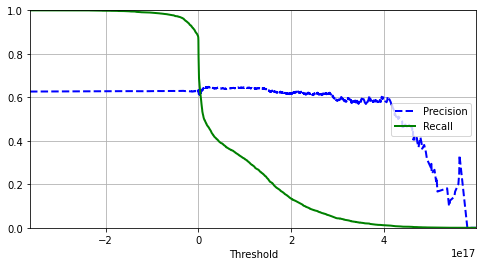

In [16]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.axis([floor(thresholds[0]), ceil(thresholds[-1]), 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Separator

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)

In [ ]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds_forest, recalls_forest[:-1], "g-", label="Recall", linewidth=2)

plt.axis([0, 1, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
y_predict = cross_val_predict(knn, X_train_prepared, y_train, cv=3)

cm = confusion_matrix(y_train, y_predict > 0)
print(cm)
print(cm[1,1]/(cm[1,1]+cm[0,1])*100)
print(cm[1,1]/(cm[1,1]+cm[1,0])*100)

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual='auto', random_state=42, tol=1e-05)
y_predict = cross_val_predict(svc, X_train_prepared, y_train, cv=3)

cm = confusion_matrix(y_train, y_predict > 0)
print(cm)
print(cm[1,1]/(cm[1,1]+cm[0,1])*100)
print(cm[1,1]/(cm[1,1]+cm[1,0])*100)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(random_state=42)
y_predict = cross_val_predict(dec_tree, X_train_prepared, y_train, cv=3)

cm = confusion_matrix(y_train, y_predict > 0)
print(cm)
print(cm[1,1]/(cm[1,1]+cm[0,1])*100)
print(cm[1,1]/(cm[1,1]+cm[1,0])*100)

In [ ]:
pd.DataFrame(y_train).value_counts()